In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import os
from IPython.display import Image, display

FVM 數值工具

In [3]:
def gradient_fd(f, dx):
    """一維中央差分梯度，邊界 One-sided"""
    grad = np.zeros_like(f)
    grad[1:-1] = (f[2:] - f[:-2]) / (2.0 * dx)
    grad[0] = (-3.0 * f[0] + 4.0 * f[1] - f[2]) / (2.0 * dx)
    grad[-1] = (3.0 * f[-1] - 4.0 * f[-2] + f[-3]) / (2.0 * dx)
    return grad


def build_u_center_and_u_face(rho, dx, D, rho_L, rho_R):
    """
    建構速度 u = -D * grad(ln rho)
    """
    nx = rho.size
    rho_ext = np.empty(nx + 2)
    rho_ext[1:-1] = rho
    rho_ext[0] = rho_L
    rho_ext[-1] = rho_R

    # 加上 clip 防止 log(0)
    log_rho_ext = np.log(np.clip(rho_ext, 1e-12, None))

    # Cell-center velocity
    u_center = -D * (log_rho_ext[2:] - log_rho_ext[:-2]) / (2.0 * dx)

    # Face velocity: 內部平均，邊界差分
    u_face = np.zeros(nx + 1)
    u_face[1:-1] = 0.5 * (u_center[:-1] + u_center[1:])
    u_face[0] = -D * 2.0 * (log_rho_ext[1] - log_rho_ext[0]) / dx
    u_face[-1] = -D * 2.0 * (log_rho_ext[-1] - log_rho_ext[-2]) / dx

    return u_center, u_face


def upwind_flux(q_L, q_R, u_face):
    """Upwind 通量"""
    return u_face * (q_L if u_face > 0.0 else q_R)

I, Y, R

In [4]:
def solve_fvm_I(I_n, u_face, dx, dt):
    """
    解 I_t + div(uI) = 0
    """
    nx = len(I_n)
    I_next = I_n.copy()
    flux = np.zeros(nx + 1)

    for j in range(1, nx):
        flux[j] = upwind_flux(I_n[j - 1], I_n[j], u_face[j])

    # Update interior
    I_next[1:-1] = I_n[1:-1] - (dt / dx) * (flux[2:-1] - flux[1:-2])
    return I_next


def solve_fvm_Y(Y_n, u_face, grad_u, dx, dt):
    """
    解 Y_t + u Y_x = 0
    數值上使用守恆形式修正： Y_t + (uY)_x = Y * u_x
    """
    nx = len(Y_n)
    Y_next = Y_n.copy()
    flux = np.zeros(nx + 1)

    for j in range(1, nx):
        flux[j] = upwind_flux(Y_n[j - 1], Y_n[j], u_face[j])

    advec = -(dt / dx) * (flux[2:-1] - flux[1:-2])
    source = dt * (Y_n * grad_u)[1:-1]

    Y_next[1:-1] = Y_n[1:-1] + advec + source
    return Y_next


def solve_fvm_R(R_n, u_face, grad_u, r_over_I, dx, dt):
    """
    解 R_t + div(uR) = R div(u) + r/I
    """
    nx = len(R_n)
    R_next = R_n.copy()
    flux = np.zeros(nx + 1)

    for j in range(1, nx):
        flux[j] = upwind_flux(R_n[j - 1], R_n[j], u_face[j])

    advec = -(dt / dx) * (flux[2:-1] - flux[1:-2])
    source = dt * ((R_n * grad_u)[1:-1] + r_over_I[1:-1])

    R_next[1:-1] = R_n[1:-1] + advec + source
    return R_next

In [5]:
def fkpp_exact(x, t, D, x0=0.0):
    """Fisher-KPP 精確行進波解 (A-Z type)"""
    c = 5.0 * np.sqrt(D / 6.0)
    L = np.sqrt(6.0 * D)
    z = (x - c * t - x0) / L
    return 1.0 / (1.0 + np.exp(z))**2


def run_simulation_Y_scheme(D=1.0, X_MIN=-10.0, X_MAX=20.0,
                            T_MAX=10.0, NX=201, NT=1601, x0_wave=0.0):
    DX = (X_MAX - X_MIN) / NX
    DT = T_MAX / (NT - 1)

    # 網格中心
    x = X_MIN + (np.arange(NX) + 0.5) * DX

    # 初始條件
    rho0 = fkpp_exact(x, 0.0, D, x0_wave)

    # 初始化變數
    # 1. Y 初始為座標本身 Y(x,0) = x
    Y_current = x.copy()
    # 2. I 初始為 1
    I_current = np.ones_like(rho0)
    # 3. R 初始為 0
    R_current = np.zeros_like(rho0)

    rho_current = rho0.copy()

    # 紀錄歷史資料
    rho_history = np.zeros((NT, NX))
    u_history = np.zeros((NT, NX))
    
    rho_history[0] = rho_current.copy()

    # 記錄初始速度
    rho_L = fkpp_exact(X_MIN, 0.0, D, x0_wave)
    rho_R = fkpp_exact(X_MAX, 0.0, D, x0_wave)
    u_c, _ = build_u_center_and_u_face(rho_current, DX, D, rho_L, rho_R)
    u_history[0] = u_c

    time_steps = np.linspace(0.0, T_MAX, NT)

    for n in range(1, NT):
        t_n = time_steps[n - 1]
        t_np1 = time_steps[n]

        # 1. 計算速度 u
        rho_L = fkpp_exact(X_MIN, t_n, D, x0_wave)
        rho_R = fkpp_exact(X_MAX, t_n, D, x0_wave)
        u_center, u_face = build_u_center_and_u_face(
            rho_current, DX, D, rho_L, rho_R)

        # CFL clip
        max_vel = DX / DT
        u_center = np.clip(u_center, -max_vel, max_vel)
        u_face = np.clip(u_face, -max_vel, max_vel)
        grad_u = gradient_fd(u_center, DX)

        # 2. 計算反應項 r
        r = rho_current - rho_current**2
        r_over_I = r / np.clip(I_current, 1e-12, None)

        # 3. 演化 I, Y, R
        I_next = solve_fvm_I(I_current, u_face, DX, DT)
        Y_next = solve_fvm_Y(Y_current, u_face, grad_u, DX, DT)
        R_next = solve_fvm_R(R_current, u_face, grad_u, r_over_I, DX, DT)

        # 4. 邊界條件
        I_next[0], I_next[-1] = 1.0, 1.0
        R_next[0], R_next[-1] = 0.0, 0.0
        Y_next[0] = X_MIN
        Y_next[-1] = X_MAX

        # 5. 重建 rho^{n+1}
        # 關鍵：利用 Y_next 去查初始分佈 rho0
        rho0_Y = fkpp_exact(Y_next, 0.0, D, x0_wave)
        rho_next = (rho0_Y + R_next) * I_next

        # 邊界修正
        rho_next[0] = fkpp_exact(X_MIN, t_np1, D, x0_wave)
        rho_next[-1] = fkpp_exact(X_MAX, t_np1, D, x0_wave)
        rho_next = np.clip(rho_next, 1e-12, 1.0)

        # 儲存
        rho_history[n] = rho_next.copy()
        u_history[n] = u_center.copy()

        # 更新
        rho_current = rho_next
        I_current = I_next
        R_current = R_next
        Y_current = Y_next

    return x, time_steps, rho_history, u_history

視覺化

In [6]:
def plot_results(x, time_steps, rho_num, rho_ex, u_hist,
                 X_MIN, X_MAX, output_dir="results_YIR_dirichlet"):
    os.makedirs(output_dir, exist_ok=True)

    squared_error = (rho_num - rho_ex)**2
    mse_hist = np.mean(squared_error, axis=1)
    print(f"Max MSE: {np.max(mse_hist):.6e}")

    # 抽幀，避免 GIF 過大
    frame_indices = list(range(0, len(time_steps), 20))
    if frame_indices[-1] != len(time_steps) - 1:
        frame_indices.append(len(time_steps) - 1)
    
    writer = PillowWriter(fps=20)

    # --- 1. Simulation (Rho Comparison) ---
    fig1, ax1 = plt.subplots(figsize=(8, 5))
    l1, = ax1.plot([], [], 'r--', label='Numerical (Y-scheme)')
    l2, = ax1.plot([], [], 'g:', lw=3, label='Exact')
    txt1 = ax1.text(0.05, 0.9, "", transform=ax1.transAxes)
    ax1.set_xlim(X_MIN, X_MAX)
    ax1.set_ylim(-0.1, 1.1)
    ax1.set_xlabel("x")
    ax1.set_ylabel(r"$\rho$")
    ax1.set_title("Density Evolution: Y-Coordinate Scheme")
    ax1.legend()
    ax1.grid(True)

    def update1(k):
        n = frame_indices[k]
        l1.set_data(x, rho_num[n])
        l2.set_data(x, rho_ex[n])
        txt1.set_text(f"t={time_steps[n]:.2f}, MSE={mse_hist[n]:.2e}")
        return l1, l2, txt1

    anim1 = FuncAnimation(fig1, update1, frames=len(frame_indices), interval=50, blit=True)
    sim_path = os.path.join(output_dir, "simulation.gif")
    anim1.save(sim_path, writer=writer)
    plt.close(fig1)
    print(f"Saved {sim_path}")

    # --- 2. MSE Evolution ---
    fig2, ax2 = plt.subplots(figsize=(8, 5))
    l3, = ax2.plot([], [], 'b-', label='Squared Error')
    txt2 = ax2.text(0.05, 0.9, "", transform=ax2.transAxes)
    ax2.set_xlim(X_MIN, X_MAX)
    max_sq_err = np.max(squared_error)
    ax2.set_ylim(0, max_sq_err*1.1 if max_sq_err > 0 else 1.0)
    ax2.set_xlabel("x")
    ax2.set_ylabel("Error^2")
    ax2.set_title("Pointwise Squared Error")
    ax2.grid(True)

    def update2(k):
        n = frame_indices[k]
        l3.set_data(x, squared_error[n])
        txt2.set_text(f"t={time_steps[n]:.2f}")
        return l3, txt2

    anim2 = FuncAnimation(fig2, update2, frames=len(frame_indices), interval=50, blit=True)
    mse_path = os.path.join(output_dir, "mse.gif")
    anim2.save(mse_path, writer=writer)
    plt.close(fig2)
    print(f"Saved {mse_path}")

    # --- 3. Velocity (u) ---
    fig3, ax3 = plt.subplots(figsize=(8, 5))
    l4, = ax3.plot([], [], 'm-', label='Velocity (u)')
    txt3 = ax3.text(0.05, 0.9, "", transform=ax3.transAxes)
    ax3.set_xlim(X_MIN, X_MAX)

    # Auto-scale y-axis
    u_min, u_max = np.min(u_hist), np.max(u_hist)
    u_range = u_max - u_min
    if u_range == 0:
        u_range = 1.0
    ax3.set_ylim(u_min - 0.1*u_range, u_max + 0.1*u_range)

    ax3.set_xlabel("x")
    ax3.set_ylabel("u")
    ax3.set_title("Velocity Evolution: u = -D grad(ln rho)")
    ax3.legend()
    ax3.grid(True)

    def update3(k):
        n = frame_indices[k]
        l4.set_data(x, u_hist[n])
        txt3.set_text(f"t={time_steps[n]:.2f}")
        return l4, txt3

    anim3 = FuncAnimation(fig3, update3, frames=len(frame_indices), interval=50, blit=True)
    vel_path = os.path.join(output_dir, "velocity.gif")
    anim3.save(vel_path, writer=writer)
    plt.close(fig3)
    print(f"Saved {vel_path}")
    
    return sim_path, mse_path, vel_path

開始執行 Y-Scheme 模擬...
Max MSE: 6.111867e-05
Saved results_YIR_dirichlet\simulation.gif
Saved results_YIR_dirichlet\mse.gif
Saved results_YIR_dirichlet\velocity.gif
模擬完成。

1. Density Evolution (Numerical vs Exact):


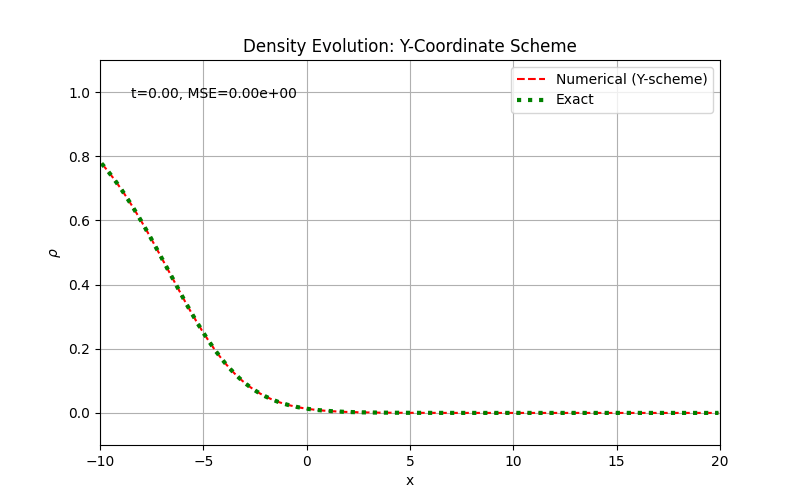


2. Pointwise Squared Error:


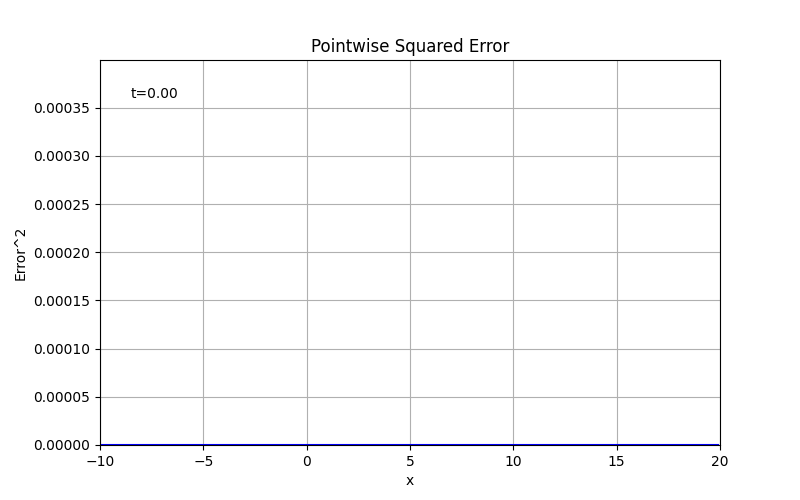


3. Velocity Field Evolution:


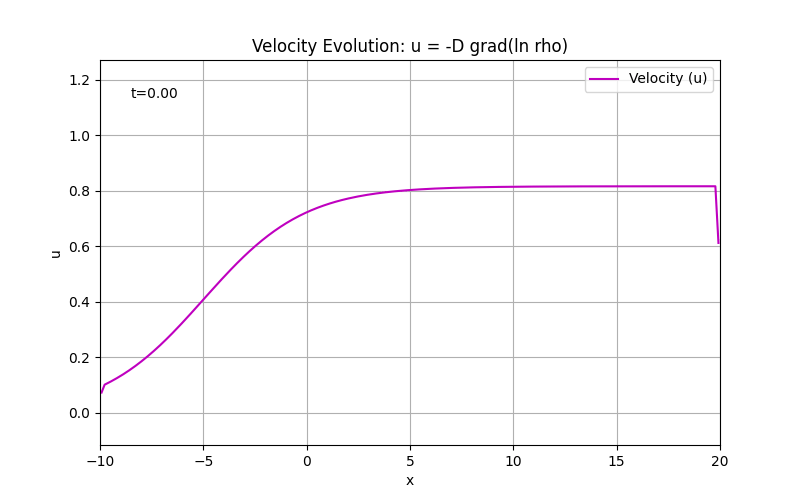

In [7]:
# 設定參數
D = 1.0
X_MIN, X_MAX = -10.0, 20.0
T_MAX = 10.0
NX, NT = 201, 1601
x0_wave = -5.0

print("開始執行 Y-Scheme 模擬...")

# 執行計算
x, t_steps, rho_n, u_h = run_simulation_Y_scheme(
    D=D, X_MIN=X_MIN, X_MAX=X_MAX, T_MAX=T_MAX,
    NX=NX, NT=NT, x0_wave=x0_wave
)

# 計算精確解以供比較
rho_ex = np.array([fkpp_exact(x, t, D, x0_wave) for t in t_steps])

# 繪圖並獲取檔案路徑
sim_path, mse_path, vel_path = plot_results(x, t_steps, rho_n, rho_ex, u_h, X_MIN, X_MAX)

print("模擬完成。")

# 顯示結果
print("\n1. Density Evolution (Numerical vs Exact):")
display(Image(filename=sim_path))

print("\n2. Pointwise Squared Error:")
display(Image(filename=mse_path))

print("\n3. Velocity Field Evolution:")
display(Image(filename=vel_path))